In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

In [2]:
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
 99% 2.28G/2.29G [00:37<00:00, 68.3MB/s]
100% 2.29G/2.29G [00:37<00:00, 65.4MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

In [0]:
import os
imagefiles=[]
labels=[]
for folder in os.listdir('/content/chest_xray/chest_xray/train'):
  path=os.path.join('/content/chest_xray/chest_xray/train',folder)
  for images in os.listdir(path):
    imagefiles.append(os.path.join(path,images))
    labels.append(folder)
testimages=[]
testlabel=[]
for folder in os.listdir('/content/chest_xray/chest_xray/test'):
  path=os.path.join('/content/chest_xray/chest_xray/test',folder)
  for images in os.listdir(path):
    testimages.append(os.path.join(path,images))
    testlabel.append(folder)
enc={}
for i,label in enumerate(os.listdir('/content/chest_xray/chest_xray/train')):
  enc[label]=i

In [0]:
labels[:10]

In [0]:
os.listdir('/content/chest_xray/chest_xray/train')
os.remove('/content/chest_xray/chest_xray/test/.DS_Store')
os.remove('/content/chest_xray/chest_xray/train/.DS_Store')
os.remove('/content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store')
os.remove('/content/chest_xray/chest_xray/train/NORMAL/.DS_Store')

In [0]:
os.remove('/content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store')

In [0]:
class Data(Dataset):
  def __init__(self,imagefiles,labels,testimages,testlabel,mode,enc=None,transform=None):
    self.imagefiles=imagefiles
    self.labels=labels
    self.testimages=testimages
    self.testlabel=testlabel
    self.mode=mode
    self.transform=transform
    self.enc=enc
  def __getitem__(self,idx):
    if self.mode=='train':
      image=Image.open(self.imagefiles[idx])
      image=np.asarray(image)
      #image = np.fromstring(image.tobytes(), dtype=np.uint8)
      #image = image.reshape((image.size[1], image.size[0], 1)) 
      image=torch.from_numpy(image)
      label=self.labels[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
    if self.mode=='test':
      image=Image.open(self.testimages[idx])
      image=np.asarray(image)
     # image = np.fromstring(image.tobytes(), dtype=np.uint8)
      #image = image.reshape((image.size[1], image.size[0], 1)) 
      image=torch.from_numpy(image)
      label=self.testlabel[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
  def __len__(self):
    if self.mode=='train':
      return len(self.imagefiles)
    if self.mode=='test':
      return len(self.testimages)
    


In [0]:
transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((100,100)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
])

In [0]:
mode1='train'
trainset=Data(imagefiles,labels,testimages,testlabel,mode1,enc,transform)

In [0]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True)

In [0]:
for img,label in trainloader:
  print(img.shape)

torch.Size([5])


torch.Size([5, 1, 100, 100])

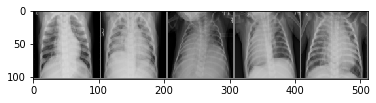

In [9]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
import matplotlib.pyplot as plt
img,lab=next(iter(trainloader))
x=torchvision.utils.make_grid(img)
imshow(x)
print(lab.shape)
img.shape

In [0]:
mode2='test'
testset=Data(imagefiles,labels,testimages,testlabel,mode2,enc,transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False)

In [0]:
for img,label in testloader:
  print(img.shape)

torch.Size([5])


torch.Size([5, 1, 100, 100])

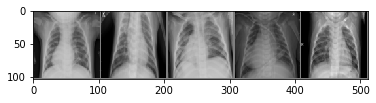

In [11]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
import matplotlib.pyplot as plt
img,lab=next(iter(testloader))
x=torchvision.utils.make_grid(img)
imshow(x)
print(lab.shape)
img.shape

In [0]:
class Encoder(nn.Module):
        ''' This the encoder part of VAE

        '''
        def __init__(self, input_dim, hidden_dim, z_dim):
            '''
            Args:
                input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
                hidden_dim: A integer indicating the size of hidden dimension.
                z_dim: A integer indicating the latent dimension.
            '''
            super().__init__()

            self.linear = nn.Linear(input_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)

        def forward(self, x):
            # x is of shape [batch_size, input_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]
            z_mu = self.mu(hidden)
            # z_mu is of shape [batch_size, latent_dim]
            z_var = self.var(hidden)
            # z_var is of shape [batch_size, latent_dim]

            return z_mu, z_var

In [0]:
class Decoder(nn.Module):
        ''' This the decoder part of VAE

        '''
        def __init__(self, z_dim, hidden_dim, output_dim):
            '''
            Args:
                z_dim: A integer indicating the latent size.
                hidden_dim: A integer indicating the size of hidden dimension.
                output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
            '''
            super().__init__()

            self.linear = nn.Linear(z_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            # x is of shape [batch_size, latent_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]

            predicted = torch.sigmoid(self.out(hidden))
            # predicted is of shape [batch_size, output_dim]

            return predicted

In [0]:
class VAE(nn.Module):
        ''' This the VAE, which takes a encoder and decoder.

        '''
        def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # encode
            z_mu, z_var = self.enc(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)

            # decode
            predicted = self.dec(x_sample)
            return predicted, z_mu, z_var

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(10000, 256, 20)

    # decoder
decoder = Decoder(20, 256, 10000)

    # vae
model = VAE(encoder, decoder)

    # optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
best_test_loss = float('inf')
patience_counter=0
for epochs in range(0,50):
  train_loss=0
  test_loss = 0
  print('Started accessing trainloader')
  for img,lab in trainloader:
    img=img.view(-1,10000)
    img=F.softmax(img)
    #img=img.to(device)
    optimizer.zero_grad()
# forward pass
    img_sample, z_mu, z_var = model(img)
   # print(f'before softmax : {img_sample}')
    #img_sample=F.softmax(img_sample)
   # print(f'after softmax : {img_sample}')
    recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
# kl divergence loss
    kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
# total loss
    loss = recon_loss + kl_loss
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  else:
    with torch.no_grad():
      print('accessing test loader')
      for img,lab in testloader:
        # reshape the data
        img = img.view(-1, 10000)
        img=F.softmax(img)
       # img=img.to(device)
        # forward pass
        img_sample, z_mu, z_var = model(img)
        #img_sample=F.softmax(img_sample)
        # reconstruction loss
        recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        # total loss
        loss = recon_loss + kl_loss
        test_loss += loss.item()

  train_loss /= len(trainloader)
  test_loss /= len(testloader)
  print(f'Epoch {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
  if best_test_loss > test_loss:
    best_test_loss = test_loss
    patience_counter = 1
  else:
    patience_counter += 1
  if patience_counter > 3:
    break

    


torch.Size([1, 20])
torch.Size([100, 100])


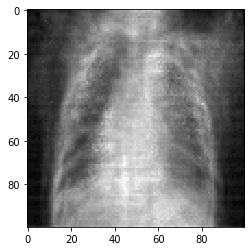

In [60]:
z = torch.randn(1, 20)
# run only the decoder
reconstructed_img = model.dec(z)
img = reconstructed_img.view(100, 100).data
print(z.shape)
print(img.shape)
plt.imshow(img,cmap='gray')